In [1]:
import sys
sys.path.append('..')

from causal_discovery_utils.cond_indep_tests import *
from causal_discovery_algs import LearnStructRAI
from graphical_models import DAG
from plot_utils import draw_graph
from experiment_utils.threshold_select_ci_test import search_threshold_bdeu

from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr
from tigramite import data_processing as pp


import numpy as np
from matplotlib import pyplot as plt
import time
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from itertools import permutations
import warnings
from scipy.stats import ConstantInputWarning
warnings.filterwarnings('ignore', category=ConstantInputWarning)

%matplotlib inline


## Utils Functions

In [2]:
def read_preprocess_data(path, subset_size):
    try:
        df = pd.read_csv(path, delimiter=";")
        df = df.tail(subset_size)
        df = df.loc[:, (df != df.iloc[0]).any()] # Drop columns that are entirely the same
        df = df.dropna(axis=1, how='all') # Drop columns that are entirely NaN
        df['Timestamp'] = df[' Timestamp'].str.strip()
        df['Timestamp'] = pd.to_datetime(df['Timestamp'], format="%d/%m/%Y %I:%M:%S %p")
        df.set_index('Timestamp', inplace=True)
        columns_to_drop = [' Timestamp', 'Normal/Attack']
        df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)
        return df

    except FileNotFoundError:
        print("File not found")
        return None
    
# Normalization of the dataset
def int_plus_normalization(dataset):
    scaler = MinMaxScaler(feature_range=(0, 3))  #se aumentato il range ci mette troppo a convergere
    data = scaler.fit_transform(dataset)
    data = data.astype(int)
    return data


def run_rai(data, th_rai, graph_nodes, CITest):
    ci_test_rai = CITest(dataset=data,threshold=th_rai, count_tests=True)
    start = time.time()
    rai = LearnStructRAI(nodes_set=graph_nodes, ci_test=ci_test_rai)
    rai.learn_structure()
    #print only first 2 decimals

    print ("Time: "+ str(time.time()-start) +" s")
    print("Total Number of CI Test: "+ str(sum(ci_test_rai.test_counter)))
    return rai, ci_test_rai


def ci_test_plot(ci_test_rai, num_ci_order_to_plot = 10):
        ci_orders = np.array(range(num_ci_order_to_plot), dtype=float)

        plt.figure()
        plt.bar(ci_orders-0.15, ci_test_rai.test_counter[0:num_ci_order_to_plot], width=0.3, align='center',
                color=[0, 0.25, 0.25])
        plt.title('number of CI test')
        plt.xlabel('conditioning set size')
        plt.legend(['RAI'])
        plt.show()


# Executes the PCMCI causal discovery algorithm
def run_pcmci(data, subset_size):
    start_time = time.time()
    pcmci = PCMCI(dataframe=data, cond_ind_test=ParCorr())
    results = pcmci.run_pcmci(tau_max=1, pc_alpha=0.05, alpha_level = 0.0001)
    print('N° of CITEST : ' + str(len(pcmci.cond_ind_test.ci_results)))
    end_time = time.time()
    print("Time taken for PCMCI with subset size ", subset_size, " - ", end_time - start_time)

    return results

# Plot for PCMCI
def plot_and_extract_links(results, df, graph_name_prefix):
    tp.plot_graph(
        val_matrix=results['val_matrix'],
        graph=results['graph'],
        var_names=list(df.columns.values),
        link_colorbar_label='MCI',
        node_size = 0.1,
        arrow_linewidth=3,
        figsize=(10,10),
        node_colorbar_label='auto-MCI',
        show_autodependency_lags=False
        )
    plt.title(graph_name_prefix + " - MCI Graph")
    plt.show()

def connection(graph, node_i, node_j):

    return True if node_j in graph._graph[node_i] else False

def hamming_distance(DAG1, DAG2):
    shd_edge = {'missing': 0, 'extra': 0, 'common' : 0}
    for (node_i, node_j) in permutations(DAG2._graph, 2):
        if not connection(DAG1,node_i, node_j):  # if edge is missing from the tested graph
            if connection(DAG2,node_i, node_j):  # if edge exists in true graph
                shd_edge['missing'] += 1
        elif not connection(DAG2,node_i, node_j):  # edge exists in tested graph; check is missing from true
            shd_edge['extra'] += 1
        else:  # edge exists in both true and tested graphs
            shd_edge['common'] += 1

    shd_total = sum(shd_edge.values())
    return shd_total, shd_edge


# Introduction to RAI
Recursive autonomy identifier (RAI) algorithm learns the structure by sequential application of __Conditional Independence__ (CI) tests, __edge direction__ (conducted according to orientation rules) and __structure decomposition__ into sub-structures.
 
The sequence of operations is performed recursively for each sub-structure.

<div style="text-align:center">
    <img src="RAI.png" alt="RAI.png" width="500">
</div>

# RAI with Normal Dataset

In [3]:
SUBSET_SIZE = 5000
normal_df_rai = read_preprocess_data("swat_dset/swat_csv/SWaT_Dataset_Normal_v1.csv", SUBSET_SIZE)

dataset = normal_df_rai.values
CITest = CondIndepCMI
th_range = [i / 10000 + 0.01 for i in range(300)]  # Range of thresholds to test

In [4]:
data = int_plus_normalization(dataset)  # Normalize data
th_rai, all_scores_rai = search_threshold_bdeu(LearnStructRAI, data, CITest, th_range) # Search for the best threshold

print('Selected RAI threshold = {:.4f}'.format(th_rai))

Selected RAI threshold = 0.0161


In [5]:
# Load the best threshold
#th_rai = np.load("th_rai.npy") 
#all_scores_rai = np.load("all_scores_rai.npy")
#print('Selected RAI threshold = {:.4f}'.format(th_rai))

In [6]:
n_samples,n_vars = data.shape   
graph_nodes = set(range(n_vars))    

## CI Test
Performed by __thresholding__ the value of a __criterion that measures the dependence between the nodes__ conditioned on a set of n nodes

Time: 6.236535549163818 s
Total Number of CI Test: 3895


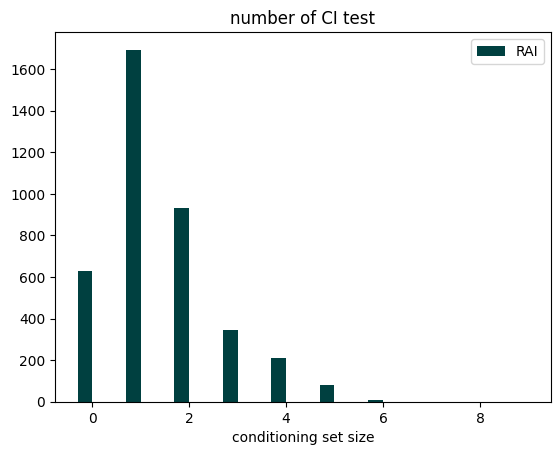

In [7]:
rai, ci_test_rai = run_rai(data, th_rai, graph_nodes, CITest)

ci_test_plot(ci_test_rai)

In [8]:
rai_dag = DAG(rai.graph.nodes_set)
rai.graph.convert_to_dag(rai_dag)
dict_labels= dict(zip(range(n_vars), normal_df_rai.columns))


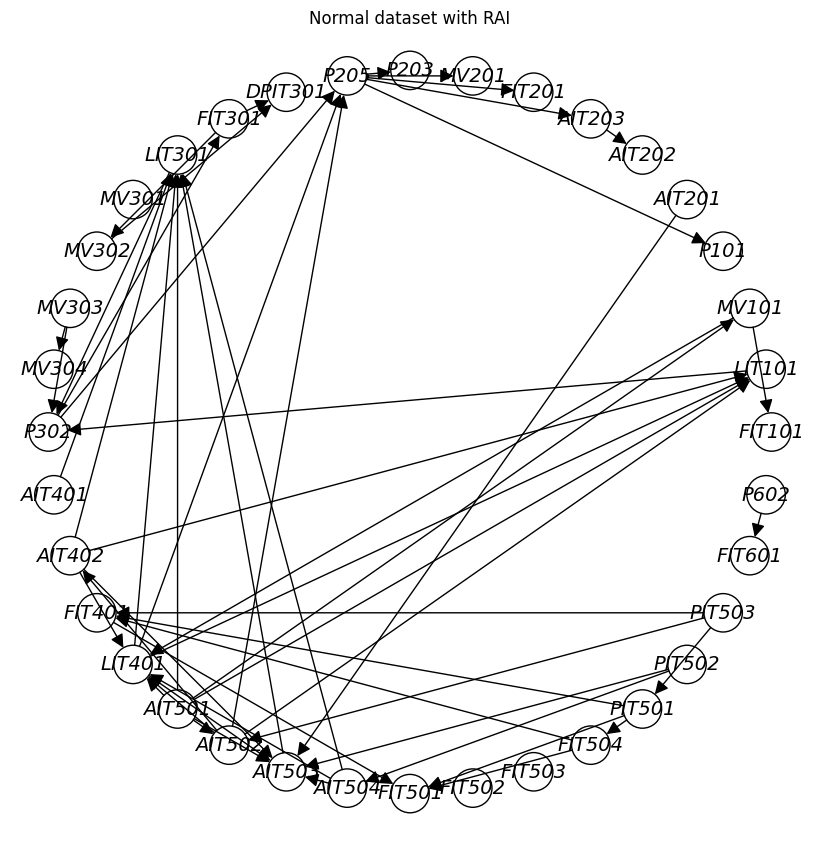

In [9]:
fig=draw_graph(rai_dag,node_size_factor=0.6, layout_type="circular",node_labels=dict_labels, x = 8, title="Normal dataset with RAI") 

# PCMCI with Normal Dataset 

In [10]:
normal_df_pcmci = read_preprocess_data("swat_dset/swat_csv/SWaT_Dataset_Normal_v1.csv", SUBSET_SIZE)
normal_data = pp.DataFrame(normal_df_pcmci.values)

In [11]:
normal_data_int = int_plus_normalization(normal_df_pcmci.values)
normal_data_int = pp.DataFrame(normal_data_int.astype(float))

N° of CITEST : 6284
Time taken for PCMCI with subset size  5000  -  65.59691572189331


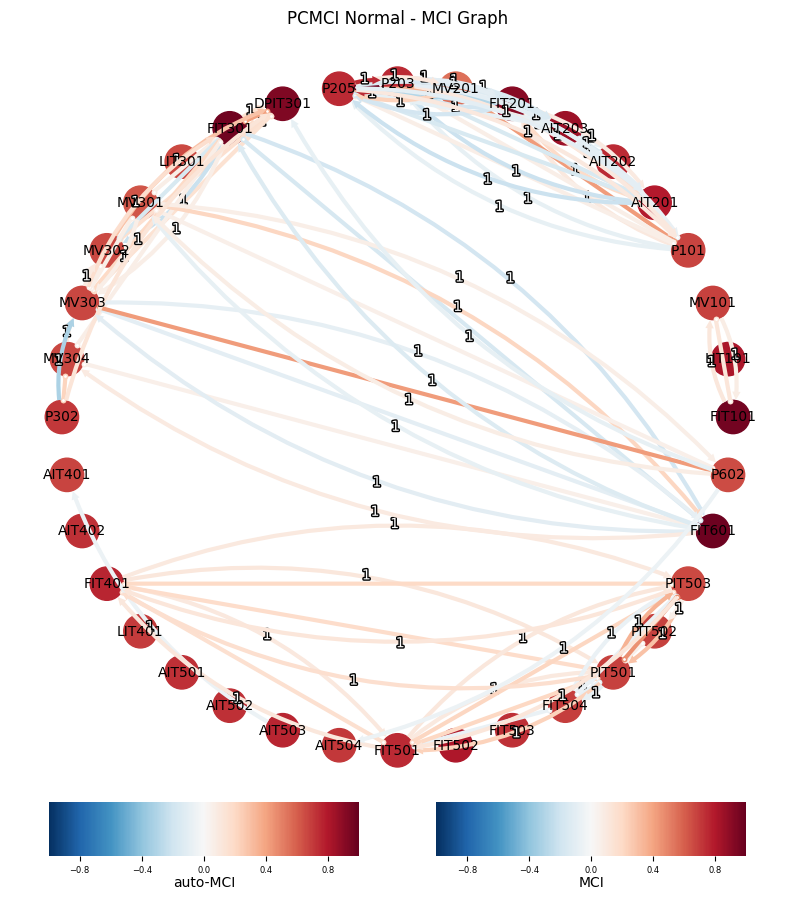

In [12]:
results_normal = run_pcmci(normal_data, subset_size=SUBSET_SIZE)
plot_and_extract_links(results_normal, normal_df_pcmci, 'PCMCI Normal')

N° of CITEST : 5797
Time taken for PCMCI with subset size  5000  -  56.59548211097717


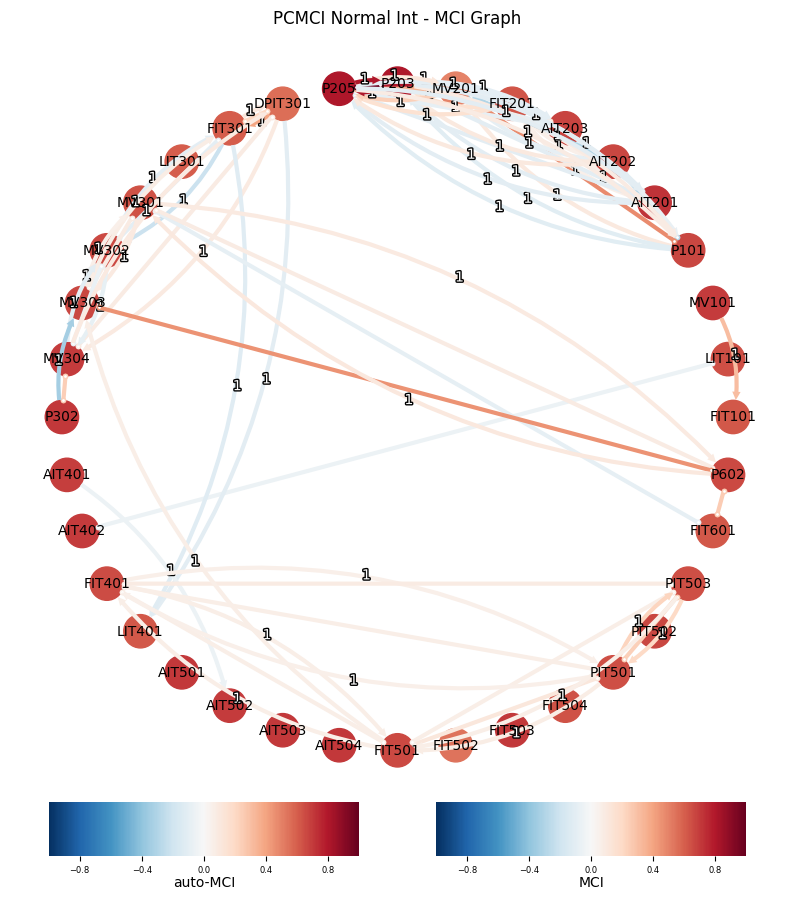

In [13]:
results_normal_int = run_pcmci(normal_data_int, subset_size=SUBSET_SIZE)
plot_and_extract_links(results_normal_int, normal_df_pcmci, 'PCMCI Normal Int')

## Hamming Distance between PCMCI (Not normalized) and RAI with Normal Dataset

In [14]:
pcmci_raw_graph = results_normal['graph'] #collegamenti verso i nodi
rai_graph = rai_dag._graph #collegamenti verso il nodo

In [15]:
pcmci_graph = {i:set() for i in range(0, n_vars)}
for i in range(n_vars):
    for j in range(n_vars):
        if i == j:
            continue
        else:
            if pcmci_raw_graph[i][j][1] == '-->':
                pcmci_graph[j].add(i)

In [16]:
#Transform the dictionary into an adj matrix
pcmci_adj_matrix = np.zeros((n_vars,n_vars))
for i in range(n_vars):
    for j in pcmci_graph[i]:
        pcmci_adj_matrix[i][j] = 1

In [17]:
pcmci_dag = DAG(graph_nodes)
pcmci_dag.init_from_adj_mat(pcmci_adj_matrix)

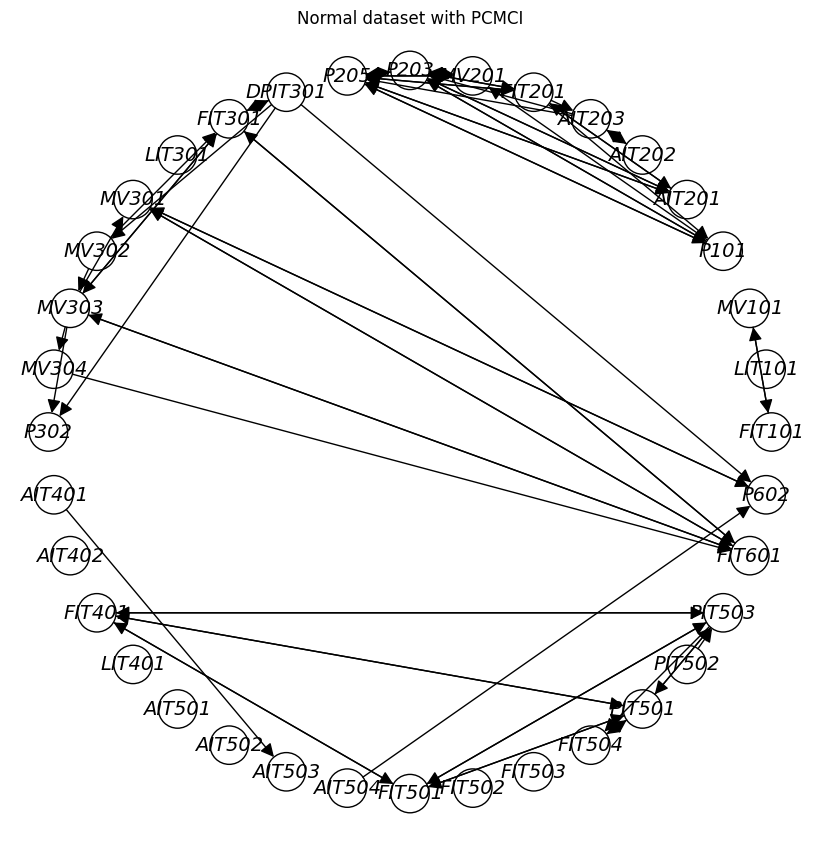

In [18]:
fig2 = draw_graph(pcmci_dag,node_size_factor=0.6, layout_type="circular",node_labels=dict_labels, x = 8, title="Normal dataset with PCMCI") 

In [19]:
hd_tot, hd_edge = hamming_distance(rai_dag, pcmci_dag) #Best results with subsize 5000
print(str(hd_edge['common']) + ' edges in common \n' + str(hd_edge['missing']) + ' edges exist only in PCMCI  \n' + str(hd_edge['extra']) + ' edges exist only in RAI\n')

15 edges in common 
53 edges exist only in PCMCI  
38 edges exist only in RAI



## Hamming Distance between PCMCI (Normalized) and RAI with Normal Dataset

In [20]:
pcmci_raw_graph_int = results_normal_int['graph'] #collegamenti verso i nodi


In [21]:
pcmci_graph_int = {i:set() for i in range(0, n_vars)}
for i in range(n_vars):
    for j in range(n_vars):
        if i == j:
            continue
        else:
            if pcmci_raw_graph_int[i][j][1] == '-->':
                pcmci_graph_int[j].add(i)

In [22]:
pcmci_adj_matrix_int = np.zeros((n_vars,n_vars))
for i in range(n_vars):
    for j in pcmci_graph_int[i]:
        pcmci_adj_matrix_int[i][j] = 1

In [23]:
pcmci_dag_int = DAG(graph_nodes)
pcmci_dag_int.init_from_adj_mat(pcmci_adj_matrix_int)

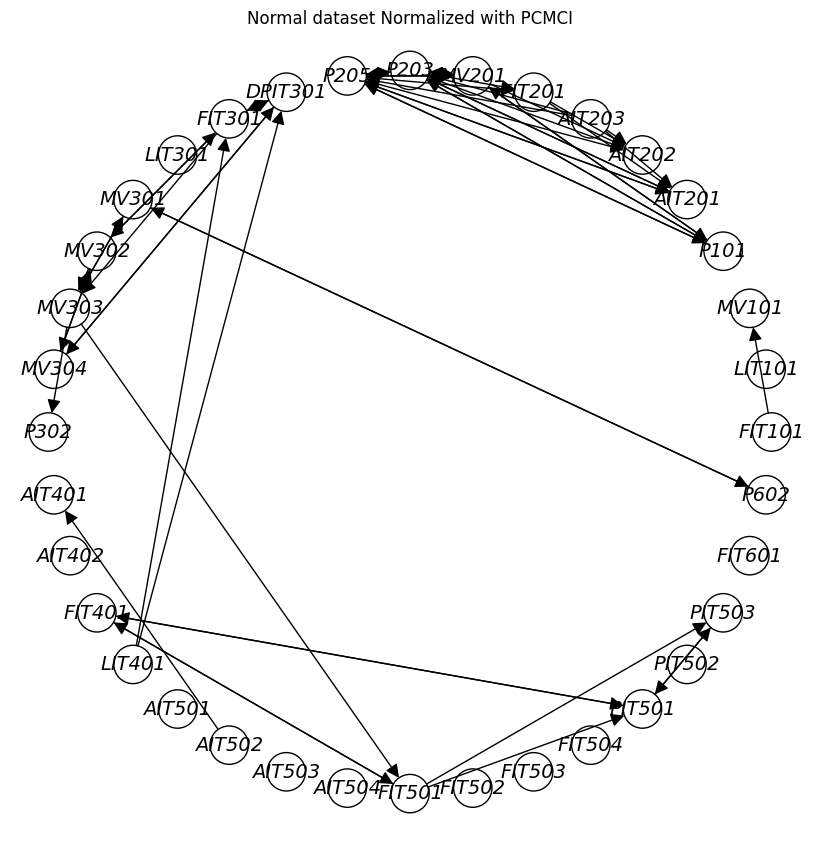

In [34]:
fig3 = draw_graph(pcmci_dag_int,node_size_factor=0.6, layout_type="circular",node_labels=dict_labels, x = 8, title="Normal dataset Normalized with PCMCI") 

In [25]:
hd_tot_int, hd_edge_int = hamming_distance(rai_dag, pcmci_dag_int) #Best results with subsize 5000
print(str(hd_edge_int['common']) + ' edges in common \n' + str(hd_edge_int['missing']) + ' edges exist only in PCMCI  \n' + str(hd_edge_int['extra']) + ' edges exist only in RAI\n')

11 edges in common 
44 edges exist only in PCMCI  
42 edges exist only in RAI



## Hamming distance between Normal and Attack dataset using RAI

In [26]:
attack_df_rai = read_preprocess_data("swat_dset/swat_csv/SWaT_Dataset_Attack_v0.csv", 5000)
attack_df_rai = attack_df_rai.drop(' P201',axis=1) #drop the column that dont exist in the normal_df_rai
dataset_atk = attack_df_rai.values
CITest = CondIndepCMI

In [27]:
data_atk = int_plus_normalization(dataset_atk)
th_rai_atk, all_scores_rai_atk = search_threshold_bdeu(LearnStructRAI, data_atk, CITest, th_range)
print('Selected RAI threshold = {:.4f}'.format(th_rai_atk))

Selected RAI threshold = 0.0343


In [28]:
n_samples_atk,n_vars_atk = data_atk.shape
graph_nodes_atk = set(range(n_vars_atk))

In [29]:
rai_atk, ci_test_rai_atk = run_rai(data_atk, th_rai_atk, graph_nodes_atk, CITest)

Time: 5.238196849822998 s
Total Number of CI Test: 3693


In [30]:
rai_dag_atk = DAG(rai_atk.graph.nodes_set)
rai_atk.graph.convert_to_dag(rai_dag_atk)
dict_labels_atk= dict(zip(range(n_vars_atk), attack_df_rai.columns))

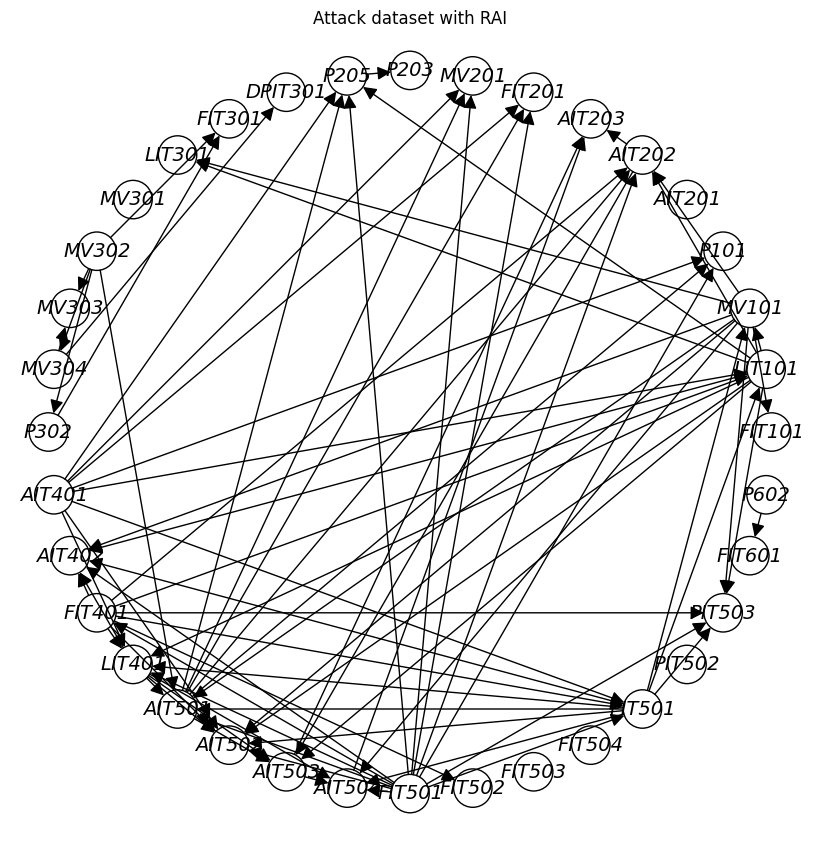

In [31]:
fig3 = draw_graph(rai_dag_atk,node_size_factor=0.6, layout_type="circular",node_labels=dict_labels, x = 8, title="Attack dataset with RAI") 

In [32]:
hd_tot_atk, shd_edge = hamming_distance(rai_dag, rai_dag_atk)
print(str(shd_edge['common']) + ' edges in common \n' + str(shd_edge['missing']) + ' edges exist only in RAI Attack  \n' + str(shd_edge['extra']) + ' edges exist only in RAI Normal\n')

6 edges in common 
74 edges exist only in RAI Attack  
47 edges exist only in RAI Normal



## PCMCI - Default vs Normalized dataset
We compare the one PCMCI algorithm with the Default SWAT dataset, and same PCMCI algorithm with the normalized dataset.
We will compare the graphs of the two algorithms to see if there are any differences by checking:
- The number of edges in common
- The number of extra edges in both graphs

In [33]:
hd_tot_int, shd_edge = hamming_distance(pcmci_dag, pcmci_dag_int)
print(str(shd_edge['common']) + ' edges in common \n' + str(shd_edge['missing']) + ' edges exist only with int and normalized values \n' + str(shd_edge['extra']) + ' edges exist only with float values \n')

39 edges in common 
16 edges exist only with int and normalized values 
29 edges exist only with float values 

